## Anomaly Detection - Fraudulent Credit Card Transactions
<p>We'll use an anonymized dataset (to protect privacy) containing credit card transaction data. Similarly in real life, this dataset has a highly imbalanced positive class (very few). 
    
The Approach:
<ul>
<li>Import libraries, load and view the dataset, ensure correct datatypes, convert ?/blanks/etc. into nan, and run basic exploratory analysis </li>
<li>Use Isloation Random Forest algorithm (an ensemble algorithm) </li>
<li>Use Local Outlier Factor Algorithm </li>
<li>Use One Class SVM Algorithm</li>
</ul>

### Part One: Initialization, Imports, Basic EDA
#### Import libraries, load and view the dataset, ensure correct datatypes, convert ?/blanks/etc. into nan, and run basic exploratory analysis

In [307]:
#Data
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
from matplotlib import pyplot as plt

#Machine Learning for Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [227]:
#Load in data
transactions_df = pd.read_csv('Data/credit_card_transactional_data.csv')

In [228]:
#Investigate Data
transactions_df.head()

,Timestamp,Value,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,Class
0,152212.22220,1.816,13.245219,NaN,16.367516,0.029326,1.278423,2.748137,-1.331457,0.065879,-0.104518,-0.037517,-250.000000,-0.475633,0
1,159074.44440,163.568,4.401403,0.084682,-313.000000,0.001888,-0.103762,1.115678,NaN,0.062966,0.130546,-0.303582,NaN,NaN,0
2,43127.77778,24.000,-9.067399,0.762501,NaN,0.052481,-0.101681,-88.000000,0.117912,NaN,0.358812,-0.367016,NaN,361.000000,0
3,156042.22220,8.000,8.728304,-0.382673,NaN,-0.116056,-0.122346,-44.000000,-338.000000,0.042154,-0.261259,-0.103974,NaN,-1.654373,0
4,154720.00000,59.496,7.657141,0.150611,NaN,-0.034883,0.826100,0.357556,0.147640,NaN,0.080491,-0.693792,-0.308631,0.563570,0


In [229]:
#See Size
transactions_df.shape

(140000, 15)

In [230]:
#Basic Exploration of Data
transactions_df.describe()

,Timestamp,Value,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,Class
count,140000.000000,140000.000000,116232.000000,129731.000000,129693.000000,140000.000000,129678.000000,116529.000000,125595.000000,129645.000000,140000.000000,129891.000000,125695.000000,125833.000000,140000.000000
mean,105334.592698,71.102883,-13.647954,-15.797094,-16.141105,0.000037,-15.540173,-13.681959,-14.760374,-16.067148,0.000119,-16.029764,-15.500080,-15.491673,0.001807
std,52763.641695,212.359700,224.599903,72.631165,74.585111,0.031540,72.120519,230.871123,235.313604,73.148242,0.215636,73.378542,237.289210,236.485713,0.042472
min,0.000000,0.000000,-2000.000000,-500.000000,-500.000000,-0.212540,-500.000000,-2000.000000,-1999.000000,-500.000000,-1.544515,-500.000000,-1998.000000,-2000.000000,0.000000
25%,60107.500002,4.400000,-6.419730,-0.262951,-9.288367,-0.017731,-0.205542,-1.149444,-0.108129,-0.033800,-0.143551,-0.509781,-0.277642,-0.596404,0.000000
50%,94276.111110,17.584000,-1.250014,-0.019520,-1.739613,-0.000140,0.000903,0.279868,0.023023,-0.005629,0.003731,-0.062414,-0.019975,0.007491,0.000000
75%,154845.833375,61.522000,5.063801,0.220734,6.436411,0.017776,0.206203,1.092373,0.109777,0.022194,0.140835,0.327266,0.224548,0.507399,0.000000
max,191985.555600,20552.928000,2000.000000,100.000000,196.401291,0.278668,100.000000,1999.000000,1998.000000,100.000000,0.858579,100.000000,2000.000000,1999.000000,1.000000


In [231]:
#Investigate Class imbalances
transactions_df.Class.value_counts()

0    139747
1       253
Name: Class, dtype: int64

In [232]:
#Investigate NA
transactions_df.isna().sum()

Timestamp        0
Value            0
C1           23768
C2           10269
C3           10307
C4               0
C5           10322
C6           23471
C7           14405
C8           10355
C9               0
C10          10109
C11          14305
C12          14167
Class            0
dtype: int64

In [233]:
#Perform Imputation #Median is not affected by outliers #KNNimpute would work well, but is computationally expensive
transactions_df.fillna(transactions_df.median(), inplace=True)

In [234]:
#Confirm NA's have been removed
transactions_df.isna().sum()

Timestamp    0
Value        0
C1           0
C2           0
C3           0
C4           0
C5           0
C6           0
C7           0
C8           0
C9           0
C10          0
C11          0
C12          0
Class        0
dtype: int64

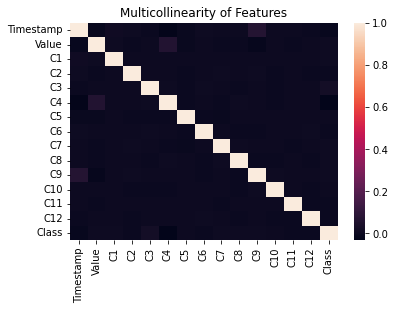

In [235]:
#Investigate Data for Multicollinearity
sns.heatmap(transactions_df.corr())
plt.title('Multicollinearity of Features')
plt.show()

### Part Two: Isolation Forest
#### Use isloation random forest algorithm (an ensemble algorithm)

In [236]:
#As this is an unsupervised algo we won't split the data and pretend we do not have the labels #no need to split
X = transactions_df.drop(columns=['Class', 'Timestamp', 'Value'])
y = transactions_df['Class']

In [225]:
#Labels will be used to calculate contamination which normally comes from industry expertise
y.value_counts(normalize=True)

0    0.998193
1    0.001807
Name: Class, dtype: float64

In [188]:
#Instantiate Isolation Forest Model
if_model = IsolationForest(n_estimators=500, contamination=0.001807)

In [239]:
#Fit model
if_model.fit(X)

C:\Users\saisu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001807, n_estimators=500)

In [243]:
#predicted score # 1 - anomaly score #Since anomaly score is ~1 for outlier
#~0 is outlier, ~1 is inlier
#Get scores & predictions
predicted_scores = if_model.decision_function(X)
predicted = if_model.predict(X)

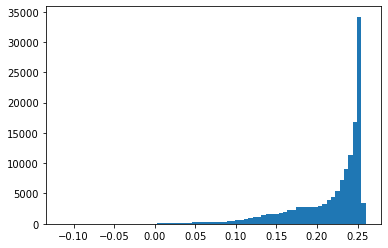

In [193]:
#Visualize using histogram to see distribtution 
plt.hist(predicted_scores, bins=70)
plt.show()

In [249]:
#Add to DF
transactions_df['score'] = predicted_scores
transactions_df['predicted'] = predicted

In [251]:
#Adjust class column for scoring
transactions_df['class_scoring'] = transactions_df.Class.apply(lambda x: -1 if x == 1 else 1)

In [252]:
#Check adjusted df
transactions_df.head()

,Timestamp,Value,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,Class,score,predicted,class_scoring
0,152212.22220,1.816,13.245219,-0.019520,16.367516,0.029326,1.278423,2.748137,-1.331457,0.065879,-0.104518,-0.037517,-250.000000,-0.475633,0,0.201398,1,1
1,159074.44440,163.568,4.401403,0.084682,-313.000000,0.001888,-0.103762,1.115678,0.023023,0.062966,0.130546,-0.303582,-0.019975,0.007491,0,0.150000,1,1
2,43127.77778,24.000,-9.067399,0.762501,-1.739613,0.052481,-0.101681,-88.000000,0.117912,-0.005629,0.358812,-0.367016,-0.019975,361.000000,0,0.171679,1,1
3,156042.22220,8.000,8.728304,-0.382673,-1.739613,-0.116056,-0.122346,-44.000000,-338.000000,0.042154,-0.261259,-0.103974,-0.019975,-1.654373,0,0.144204,1,1
4,154720.00000,59.496,7.657141,0.150611,-1.739613,-0.034883,0.826100,0.357556,0.147640,-0.005629,0.080491,-0.693792,-0.308631,0.563570,0,0.222328,1,1


### Part Three: Local Outlier Factor algorithm
#### Use Local Outlier Factor algorithm (Density Based Clustering)

In [269]:
#Instantiate LOF Model
lof = LocalOutlierFactor(novelty=True, contamination=0.001807)

In [270]:
#Train model to data
lof.fit(X)

LocalOutlierFactor(contamination=0.001807, novelty=True)

In [271]:
#Get predicted scores and predictions to add to df
predicted_scores = lof.decision_function(X)
predicted = lof.predict(X)

C:\Users\saisu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\saisu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


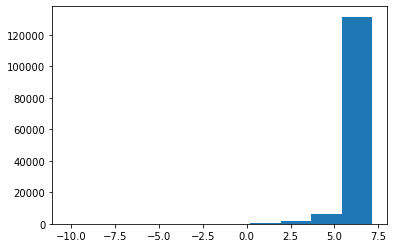

In [315]:
#Visualize using histogram to see distribtution 
plt.hist(predicted_scores, bins=10)
plt.show()

In [272]:
#Add LOF results to DF
transactions_df['lof_score'] = predicted_scores
transactions_df['lof_predicted'] = predicted

In [278]:
transactions_df.head()

,Timestamp,Value,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,Class,score,predicted,class_scoring,lof_score,lof_predicted
0,152212.22220,1.816,13.245219,-0.019520,16.367516,0.029326,1.278423,2.748137,-1.331457,0.065879,-0.104518,-0.037517,-250.000000,-0.475633,0,0.201398,1,1,6.859008,1
1,159074.44440,163.568,4.401403,0.084682,-313.000000,0.001888,-0.103762,1.115678,0.023023,0.062966,0.130546,-0.303582,-0.019975,0.007491,0,0.150000,1,1,6.891965,1
2,43127.77778,24.000,-9.067399,0.762501,-1.739613,0.052481,-0.101681,-88.000000,0.117912,-0.005629,0.358812,-0.367016,-0.019975,361.000000,0,0.171679,1,1,5.663445,1
3,156042.22220,8.000,8.728304,-0.382673,-1.739613,-0.116056,-0.122346,-44.000000,-338.000000,0.042154,-0.261259,-0.103974,-0.019975,-1.654373,0,0.144204,1,1,6.644320,1
4,154720.00000,59.496,7.657141,0.150611,-1.739613,-0.034883,0.826100,0.357556,0.147640,-0.005629,0.080491,-0.693792,-0.308631,0.563570,0,0.222328,1,1,6.733855,1


In [282]:
#Convert x to numpy array for plotting
X_arr = X.to_numpy()

In [289]:
#Extract outliers
y_index = np.where(predicted==-1)
outliers = X_arr[y_index]

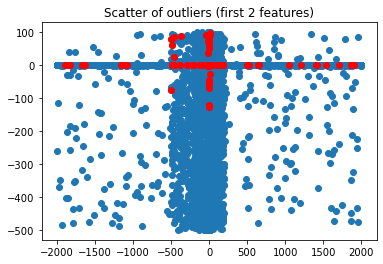

In [298]:
#Plot scatter plot of outliers
plt.scatter(X_arr[:, 0], X_arr[:, 1])
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plt.title('Scatter of outliers (first 2 features)')
plt.show()

In [ ]:
#As we can conclude, outliers are too similar to data, as such anomaly detection using this dataset is not recommended.

### Part Four: Support Vector Machine
#### Use One Class SVM Algorithm

In [299]:
#Instantiate one class svm, keep strict nu, small margin, low misclassification
one_svm = OneClassSVM(nu=0.01)

In [301]:
#Train Model
one_svm.fit(X)

OneClassSVM(nu=0.01)

In [302]:
#Get predictions
predictions = one_svm.predict(X)

In [303]:
#Append to df
transactions_df['SVM_predictions'] = predictions

In [306]:
#View final df
transactions_df.head()

,Timestamp,Value,C1,C2,C3,C4,C5,C6,C7,C8,...,C10,C11,C12,Class,score,predicted,class_scoring,lof_score,lof_predicted,SVM_predictions
0,152212.22220,1.816,13.245219,-0.019520,16.367516,0.029326,1.278423,2.748137,-1.331457,0.065879,...,-0.037517,-250.000000,-0.475633,0,0.201398,1,1,6.859008,1,1
1,159074.44440,163.568,4.401403,0.084682,-313.000000,0.001888,-0.103762,1.115678,0.023023,0.062966,...,-0.303582,-0.019975,0.007491,0,0.150000,1,1,6.891965,1,1
2,43127.77778,24.000,-9.067399,0.762501,-1.739613,0.052481,-0.101681,-88.000000,0.117912,-0.005629,...,-0.367016,-0.019975,361.000000,0,0.171679,1,1,5.663445,1,1
3,156042.22220,8.000,8.728304,-0.382673,-1.739613,-0.116056,-0.122346,-44.000000,-338.000000,0.042154,...,-0.103974,-0.019975,-1.654373,0,0.144204,1,1,6.644320,1,1
4,154720.00000,59.496,7.657141,0.150611,-1.739613,-0.034883,0.826100,0.357556,0.147640,-0.005629,...,-0.693792,-0.308631,0.563570,0,0.222328,1,1,6.733855,1,1
